In [9]:
from koinapy import Koina
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import time
import sys
from pathlib import Path
from functools import reduce
from tqdm import tqdm
import os

# Alternative way if __file__ is not defined in Jupyter notebooks
project_root = Path.cwd().parent

sys.path.append(str(project_root))

from make_predictions.intensity_predictions import obtain_predictions_pairs
from seq_utils.fasta_to_peptides import create_tryptic_peptides
from seq_utils.peptide import remove_non_il, remove_ux_containing, switch_first_il
from metrics.get_metrics import metrics_comparison

In [10]:
# Specify the path to your FASTA file
fasta_file = "../fasta/UP000005640_9606.fasta"

# Generate tryptic peptides
peptides = create_tryptic_peptides(fasta_file)

# Remove non-I/L amino acids
peptides = remove_non_il(peptides)
peptides = remove_ux_containing(peptides)

# Create correct, switched pairs
peptides_switched = np.array([switch_first_il(peptide) for peptide in peptides])
peptides = np.array(peptides)

In [11]:
peptides_switch_predictions_f = "../temp_data/peptides_switch_predictions.csv"
peptides_predictions_f = "../temp_data/peptides_predictions.csv"

batch_size = 5000
peptides_switch_predictions_list = []
peptides_predictions_list = []

# TODO move this to make_predictions.intensity_predictions
def safe_obtain_predictions(peptides_batch, switched, max_retries=3, delay=1):
    """
    Attempts to obtain predictions for a batch of peptides, retrying in case of failure.

    Args:
        peptides_batch (list): List of peptide sequences.
        switched (bool): Parameter for prediction function.
        max_retries (int): Maximum number of retries before raising the exception.
        delay (int): Delay in seconds between retries.

    Returns:
        pd.DataFrame: DataFrame of predictions.
    """
    for attempt in range(max_retries):
        try:
            return obtain_predictions_pairs(peptides_batch, switched=switched)
        except Exception as e:
            if attempt < max_retries - 1:
                time.sleep(delay)
            else:
                raise RuntimeError(
                    f"Prediction failed after {max_retries} attempts."
                ) from e

if os.path.exists(peptides_switch_predictions_f) and os.path.exists(
    peptides_predictions_f
):
    peptides_switch_predictions = pd.read_csv(peptides_switch_predictions_f)
    peptides_predictions = pd.read_csv(peptides_predictions_f)
else:
    for i in tqdm(range(0, len(peptides), batch_size)):
        batch_switched = peptides_switched[i : i + batch_size]
        batch = peptides[i : i + batch_size]

        peptides_switch_predictions_list.append(
            safe_obtain_predictions(batch_switched, switched=False)
        )
        peptides_predictions_list.append(
            safe_obtain_predictions(batch, switched=True)
        )

    peptides_switch_predictions = pd.concat(
        peptides_switch_predictions_list,
        ignore_index=True
    )
    peptides_predictions = pd.concat(
        peptides_predictions_list, 
        ignore_index=True
    )

    peptides_switch_predictions.to_csv(
        peptides_switch_predictions_f,
        index=False,
    )
    peptides_predictions.to_csv(
        peptides_predictions_f, 
        index=False
    )

In [12]:
noise_std_dev = 0.1
num_randomizations = 10

score_df = metrics_comparison(
    peptides_predictions, 
    peptides_switch_predictions
)

score_df_randomized = metrics_comparison(
    peptides_predictions,
    peptides_switch_predictions,
    randomize_gaussian=True,
    noise_std_dev=noise_std_dev,
)

score_df_randomized_swap = metrics_comparison(
    peptides_predictions,
    peptides_switch_predictions,
    randomize_switched=True,
    num_randomizations=num_randomizations,
)

c:\Users\robbi\anaconda3\envs\py312_lorentz\Lib\site-packages\scipy\spatial\distance.py:685: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / math.sqrt(uu * vv)
c:\Users\robbi\OneDrive\Documents\GitHub\spectral_similarity\metrics\metrics.py:52: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(weights * intensity1 * intensity2) / (
c:\Users\robbi\OneDrive\Documents\GitHub\spectral_similarity\metrics\metrics.py:72: RuntimeWarning: invalid value encountered in scalar divide
  score = np.sum(prod) / (np.sqrt(np.sum(intensity1**2)) * np.sqrt(np.sum(intensity2**2)))
c:\Users\robbi\OneDrive\Documents\GitHub\spectral_similarity\metrics\metrics.py:111: RuntimeWarning: invalid value encountered in scalar divide
  return sim / (np.sqrt(np.sum(weights * intensity1**2)) * np.sqrt(np.sum(weights * intensity2**2)))
c:\Users\robbi\anaconda3\envs\py312_lorentz\Lib\site-packages\scipy\spatial\distance.py:685: RuntimeWarning: invalid value encounter

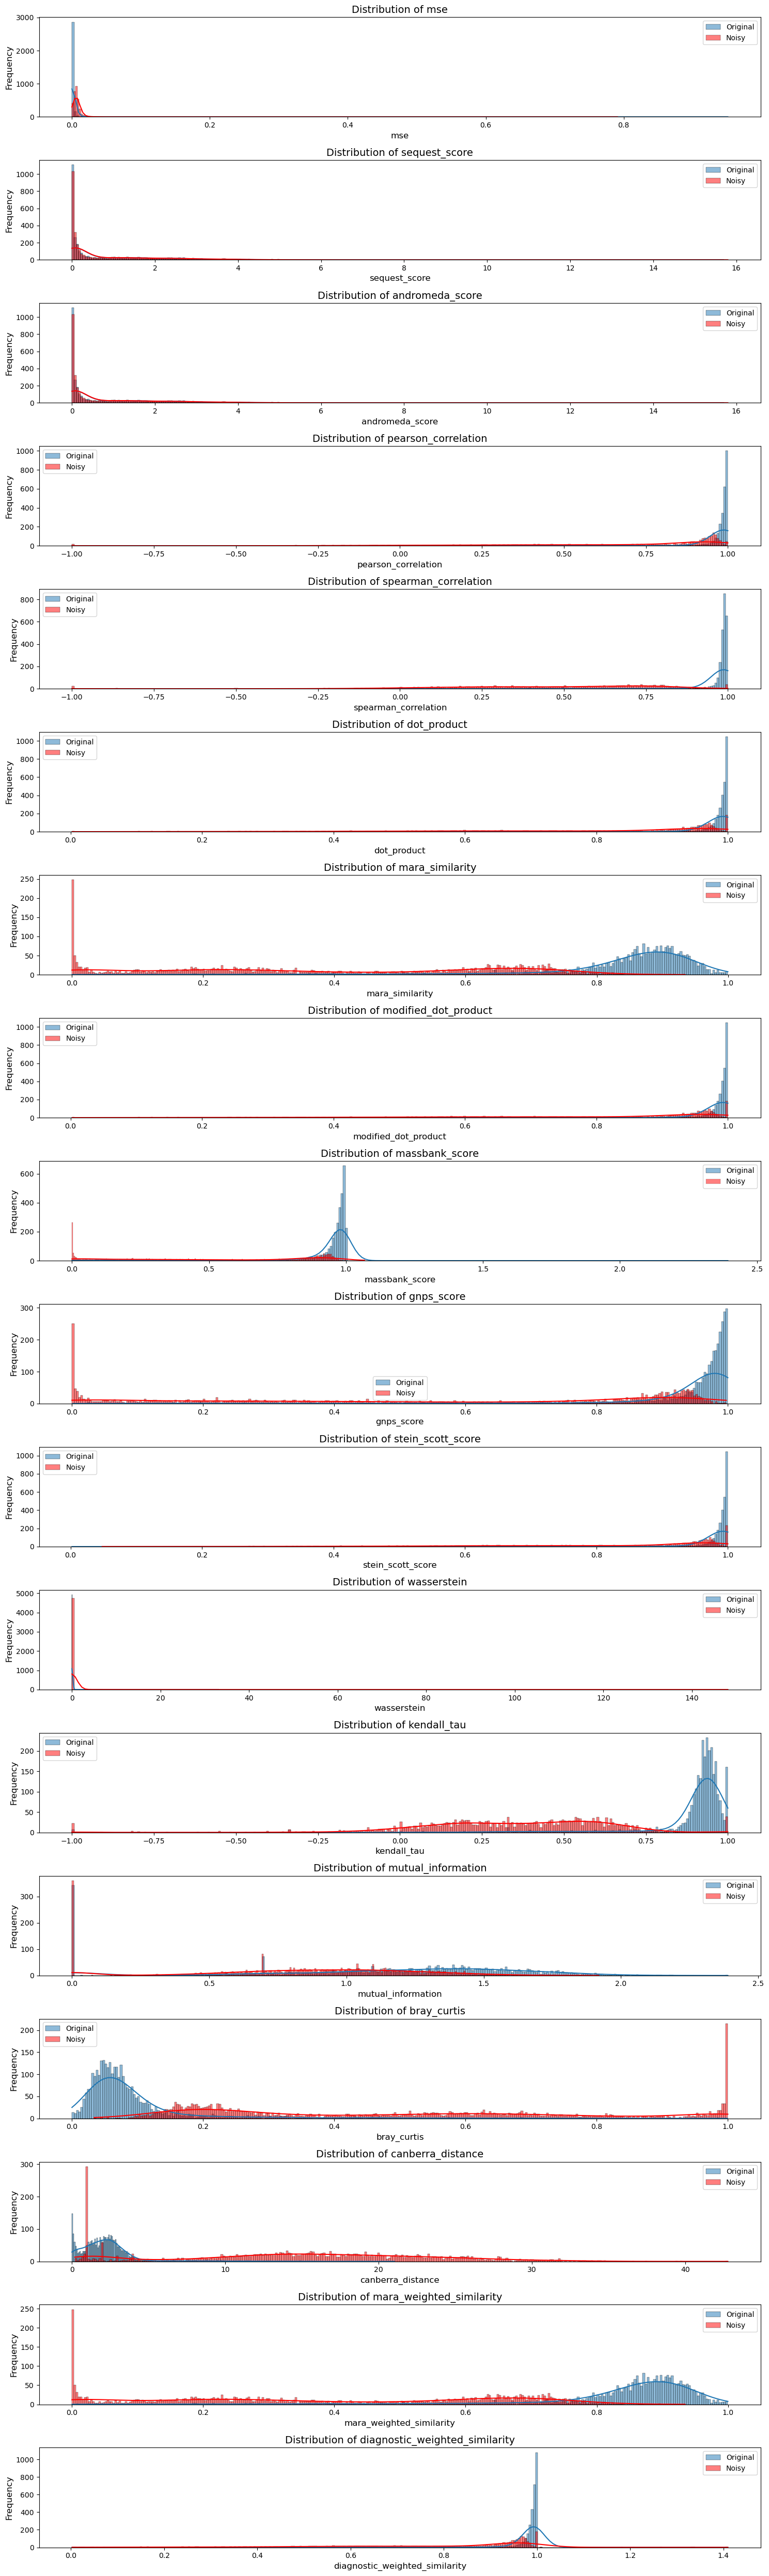

In [13]:
# Generate the distributions for each score as histograms
score_columns = score_df.columns

# Set plot size and style
plt.figure(figsize=(15, 50))
for idx, col in enumerate(score_columns, 1):
    plt.subplot(len(score_columns), 1, idx)
    sns.histplot(score_df[col], bins=300, kde=True, label="Original")
    sns.histplot(score_df_randomized[col], bins=300, kde=True, color="red", label="Noisy")
    plt.title(f"Distribution of {col}", fontsize=14)
    plt.legend()
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Frequency", fontsize=12)

plt.tight_layout()
plt.show()

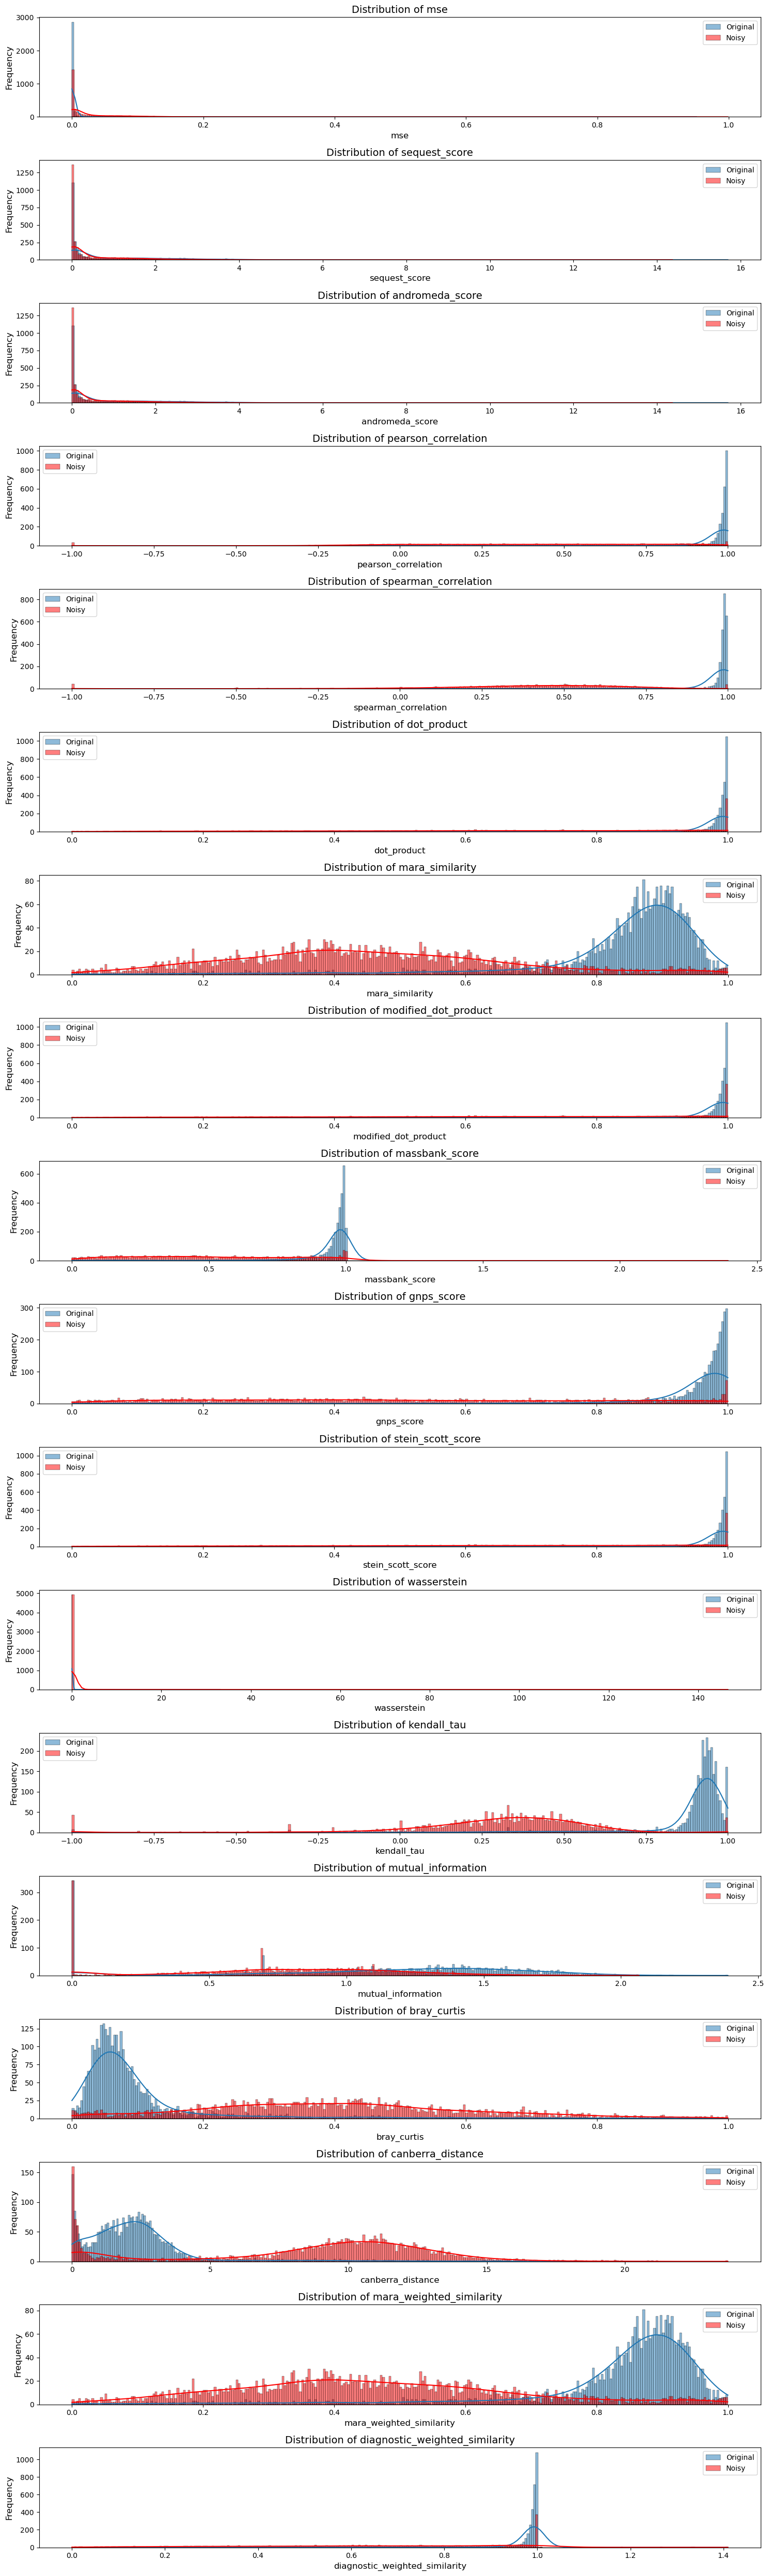

In [14]:
# Generate the distributions for each score as histograms
score_columns = score_df.columns

# Set plot size and style
plt.figure(figsize=(15, 50))
for idx, col in enumerate(score_columns, 1):
    plt.subplot(len(score_columns), 1, idx)
    sns.histplot(score_df[col], bins=300, kde=True, label="Original")
    sns.histplot(
        score_df_randomized_swap[col], bins=300, kde=True, color="red", label="Noisy"
    )
    plt.title(f"Distribution of {col}", fontsize=14)
    plt.legend()
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Frequency", fontsize=12)

plt.tight_layout()
plt.show()

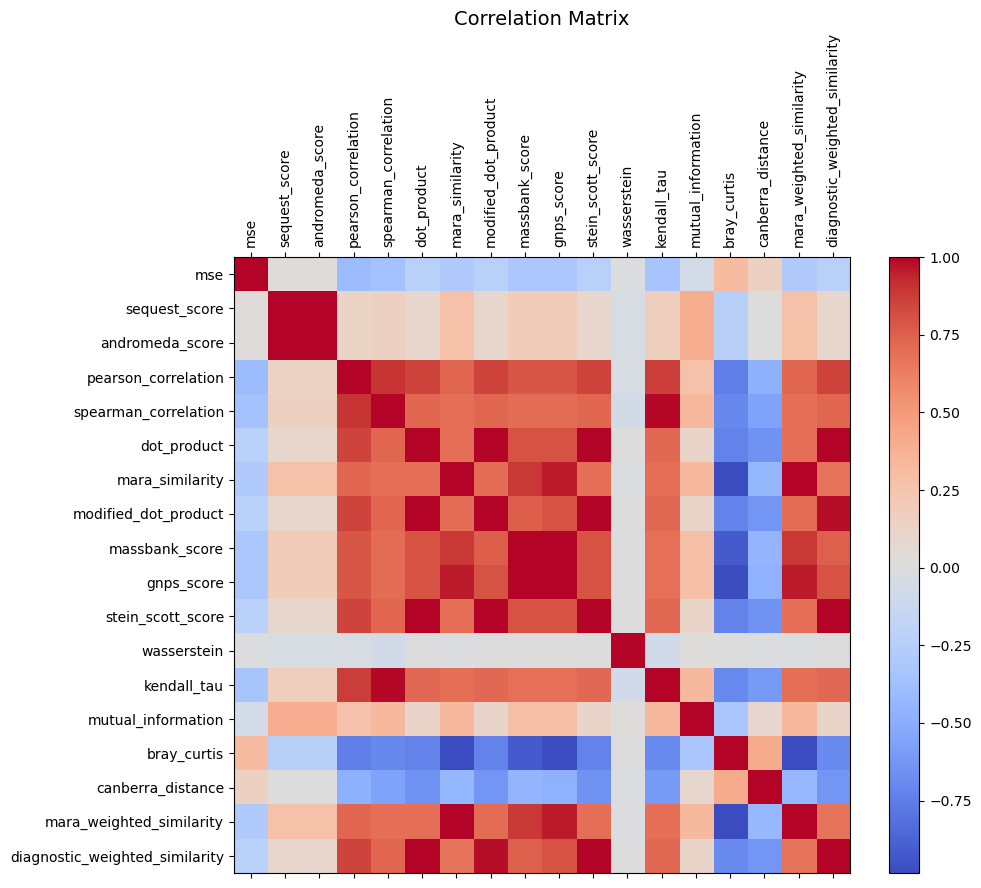

In [17]:
corr_matrix = score_df.corr()

fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(corr_matrix, cmap="coolwarm")

fig.colorbar(cax)

plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)

plt.title("Correlation Matrix", fontsize=14)
plt.show()

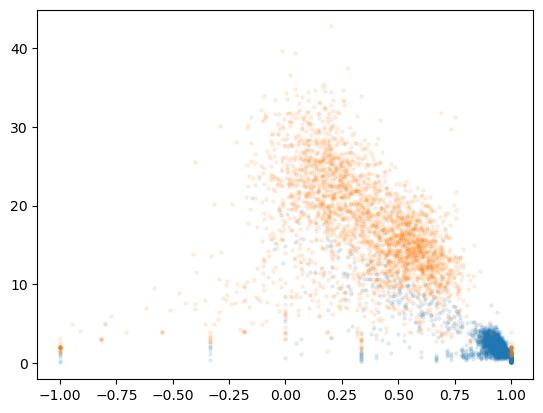

In [18]:
plt.scatter(score_df["kendall_tau"], score_df["canberra_distance"],s=5,alpha=0.1)
plt.scatter(
    score_df_randomized["kendall_tau"],
    score_df_randomized["canberra_distance"],
    s=5,
    alpha=0.1,
)